# Analysis with python notebook of all results

Steps:

1. Collect all results of the simulation on a python readable file, having done reblocking before

2. Analyze molecules, QMC versus DFT \
    a. Analysis DMC values, timestep dependence \
    b. Comparison with DFT and CCSD(T) (writes *results_mol_dft.pkl*, which also includes CCSD(T) results, and in *delta_mol_ref.pkl* the delta energy with respect to the refence molecule) \
    c. Inference of the VAR per atom from molecules

3. Analyze dimers binding energies \
    a. Do extrapolations w/ w/o Jopt on molecules \
    b. Define gold, silver, bronze schemes, and their cost

4. Compare binding energies with other references 

5. Tool to predict QMC cost \
    a. Multilinear fit of the variance \
    b. Use of Student's t distribution to estimate cost 

6. Plots for some relevant cases

7. Plots for the paper

---

## Specific tasks here:

Copy data into \
    **data[mol][method][mol_id]**, \
where method is either the DFT functional or the DMC timestep (with err_{timestep} reporting the error). 
For DMC, consider only use **DMCdla5 Jopt**, and **mol_info[mol]['test']** is True. 
Notice that **data[mol]** can be converted in a **pd.DataFrame** with mol_id as index and method as columns.  

Comparison with **HF**, **DFT** (LDA, PBE, B3LYP) and **CCSD(T) cc-pV(D,T)Z** (orca)

Write in a file the delta energy for each structure (mol_id) of each molecule \
    **delta_mol_ref[mol][mol_id] = E[mol_id] - E[ref_mol_id]** \
where E is the energy at the B3LYP level, 
such that in a molecule where only one DMC evaluation was performed, in the **ref_mol_id** structure,
we can estimate \
    **Edmc[mol][mol_id] ~ Edmc[mol][ref_mol_id] + delta_mol_ref[mol][mol_id]**



In [1]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from def_colors import map_DMC, dmc_color, dft_color

from define_setup import *

# Read mol_info
with open( 'mol_info.pkl', 'rb' ) as f:
    mol_info = pickle.load( f )
#mol_info

df_mol_info = pd.read_csv( 'mol_info.csv', index_col=0 )
df_mol_info

# Read results monomer
import pickle
with open( dir_analysis+'results_mol.pkl', 'rb' ) as f:
    results_mol = pickle.load( f )

In [2]:
list_clean = []

for mol in results_mol:
    #print(mol)
    for mol_id in results_mol[mol]:
        #print(mol_id)
        #for dmc_type in results_mol[mol][mol_id]:
            #print(dmc_type)
        if len(results_mol[mol][mol_id].keys())==0:
            print(mol,mol_id)
            list_clean.append( [mol,mol_id] )

#print(list_clean)
for l in list_clean:
    print(l)
    del results_mol[l[0]][l[1]]

Benzene 24_2
Pyridine 25_2
['Benzene', '24_2']
['Pyridine', '25_2']


In [3]:
results_mol['Uracil']['42_1']

{'DMCdla5': {'Jopt': {'0.10': {'ene': -48315.314470384,
    'err': 0.0514636823312274,
    'units': 'kcal/mol',
    'TotTimeSim[au]': 1050.0,
    'Pop': 63894.60923076923,
    'Pop-err': 1.6552408141901198,
    'Var[au]': 1.1742480369954402,
    'tau_eff[au]': 0.08782612595064569,
    'corr-time[au]': 0.3901453598826652,
    'machine': 'linuxpc-intel-slurm-parallel.peta4',
    'N_MPI': 160,
    'cost': 1.1887281699999999,
    'target_weight': 64000.0},
   '0.03': {'ene': -48309.0281047964,
    'err': 0.0492457706587826,
    'units': 'kcal/mol',
    'TotTimeSim[au]': 1215.0,
    'Pop': 63975.0608972763,
    'Pop-err': 0.8781583847974219,
    'Var[au]': 1.2526897889388504,
    'tau_eff[au]': 0.029093779969881533,
    'corr-time[au]': 0.31035964709900526,
    'machine': 'linuxpc-intel-slurm-parallel.peta4',
    'N_MPI': 160,
    'cost': 1.1776998600000002,
    'target_weight': 64000.0},
   '0.01': {'ene': -48308.9528274927,
    'err': 0.0509979738263755,
    'units': 'kcal/mol',
    'TotT

In [4]:
d = {}
for mol in results_mol.keys():
    #print(mol,mol_info[mol])
    mol_id = mol_info[mol]['ref']
    m = mol_info[mol]['atoms']
    d[mol] = { 
        1 : m['H'],
        6 : m['C'],
        7 : m['N'],
        8 : m['O'],
        'Nelv' : m['H'] + 4*m['C'] + 5*m['N'] + 6*m['O'] ,
        'Corr' : results_mol[mol][mol_id]['DMCdla5']['Jopt']['0.01']['corr-time[au]'],
        'Corr03' : results_mol[mol][mol_id]['DMCdla5']['Jopt']['0.03']['corr-time[au]'],
        'Corr10' : results_mol[mol][mol_id]['DMCdla5']['Jopt']['0.10']['corr-time[au]'],
    }

df = pd.DataFrame( d ).transpose()
df
#df.loc[:,1:8]
#df.loc[:,'Nelv']

,1,6,7,8,Nelv,Corr,Corr03,Corr10
AcNH2,5.0,2.0,1.0,1.0,24.0,0.256561,0.307369,0.343110
AcOH,4.0,2.0,0.0,2.0,24.0,0.264503,0.247693,0.342888
Benzene,6.0,6.0,0.0,0.0,30.0,0.426664,0.413099,0.478023
Cyclopentane,10.0,5.0,0.0,0.0,30.0,0.458099,0.441622,0.425833
Ethene,4.0,2.0,0.0,0.0,12.0,0.386775,0.384612,0.461466
Ethyne,2.0,2.0,0.0,0.0,10.0,0.416593,0.332409,0.445282
MeNH2,5.0,1.0,1.0,0.0,14.0,0.319718,0.353365,0.346050
MeOH,4.0,1.0,0.0,1.0,14.0,0.247038,0.244593,0.330654
Neopentane,12.0,5.0,0.0,0.0,32.0,0.405849,0.383635,0.445526
Pentane,12.0,5.0,0.0,0.0,32.0,0.398932,0.382463,0.432248


In [5]:
from scipy.optimize import curve_fit

y = df.loc[:,'Corr'].to_numpy()
X = [ df.loc[:,i].to_numpy() for i in [1,6,7,8]]
array_Nelv = df.loc[:,'Nelv'].to_numpy()
for i in range(len(X)):
    X[i] = X[i] / array_Nelv
    
def func(X, aH, aC, aN, aO ):
    x1, x6, x7, x8 = X
    return aH*x1 + aC*x6 + aN*x7 + aO*x8 

popt, pcov = curve_fit( func, xdata=X, ydata=y )
print(popt)
print(pcov)


print()
#print( f'VAR [H,C,N,O] = {popt}\n' )
#Nelv = np.array([1,4,5,6])
#print( 'VAR/Nelv [H,C,N,O] =', popt/Nelv )

yhat = func(X, *popt)
yhat

df['fit'] = yhat

residual = (y-yhat)
SSR = residual.transpose().dot(residual)
print('SSR =',SSR)

[0.35041049 1.75891976 0.82655221 0.57620486]
[[ 0.00286373 -0.00438879 -0.00283833 -0.00398549]
 [-0.00438879  0.00897935  0.00042319  0.00511318]
 [-0.00283833  0.00042319  0.05388038 -0.00121555]
 [-0.00398549  0.00511318 -0.00121555  0.02126577]]

SSR = 0.004656847678013316


0.1502022376621517 0.47276040537408576


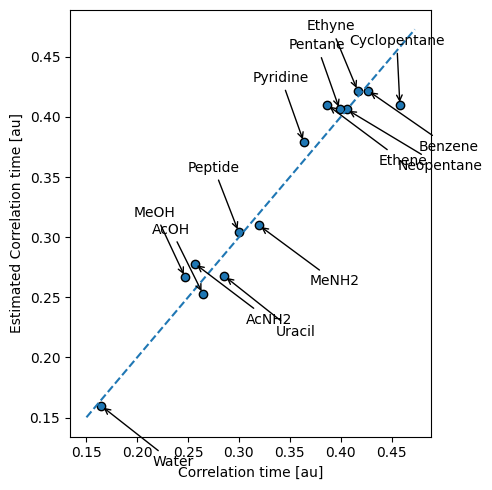

In [6]:
fig, ax = plt.subplots( figsize=(5,5) )
ax.scatter(y,yhat,edgecolors='k')
ax.set_xlabel('Correlation time [au]')
ax.set_ylabel('Estimated Correlation time [au]')

xmin, xmax = plt.xlim()
print(xmin,xmax)
xv = np.linspace(xmin,xmax,10)
ax.plot(xv,xv,'--')

dfs = df.sort_values('Corr')
n = list( dfs.index )
xn = list( dfs.Corr )
yn = list( dfs.fit )
for i in range(len(xn)):
    ax.annotate(n[i],(xn[i],yn[i]),
                xytext=(xn[i]-(i%2-0.5)*0.1,yn[i]+(i%2-0.5)*0.1),
                arrowprops=dict(facecolor='black', arrowstyle="->"))
#df
fig.tight_layout()
fig.savefig(f'FIG02d/Evaluation_Corr_fit.png',format='png',dpi=300)

# Validation with variance dimers

In [7]:
df = pd.read_csv('results_dim.csv', index_col=0)

# Read mol_info
with open( 'dim_info.pkl', 'rb' ) as f:
    dim_info = pickle.load( f )


df = df.loc[ (df.tau==0.01) & (df.dmc_type=='DMCdla5') & (df.dmc_Jas=='Jopt') ]
df.index = df.ID
df = pd.DataFrame( df['corr-time[au]'] )

for atom in dim_info[1]['atoms']:
    df[atom] = 0
df['Nelv'] = 0
for i in df.index:
    #print(i, dim_info[i]['atoms'])
    for atom in dim_info[i]['atoms']:
        df.loc[i,atom] = dim_info[i]['atoms'][atom]
        df.loc[i,'Nelv'] = dim_info[i]['Nelv']

df

,corr-time[au],H,C,N,O,Nelv
ID,,,,,,
1,0.196763,4,0,0,2,16
2,0.223646,6,1,0,2,22
3,0.264562,7,1,1,1,22
4,0.263498,9,3,1,2,38
5,0.257377,8,2,0,2,28
...,...,...,...,...,...,...
62,0.370285,17,7,1,1,56
63,0.341167,10,8,0,2,54
64,0.389777,11,5,1,1,42


In [8]:
y = df['corr-time[au]'].to_numpy()
X = [ df[i].to_numpy() for i in ['H','C','N','O']]
array_Nelv = df.loc[:,'Nelv'].to_numpy()
for i in range(len(X)):
    X[i] = X[i] / array_Nelv
#X

SSR = 0.0909633743020909
0.18060763604982574 0.5360312885733098


,corr-time[au],H,C,N,O,Nelv,fit
ID,,,,,,,
1,0.196763,4,0,0,2,16,0.159628
2,0.223646,6,1,0,2,22,0.227900
3,0.264562,7,1,1,1,22,0.255207
4,0.263498,9,3,1,2,38,0.273932
5,0.257377,8,2,0,2,28,0.266912
...,...,...,...,...,...,...,...
62,0.370285,17,7,1,1,56,0.351289
63,0.341167,10,8,0,2,54,0.346812
64,0.389777,11,5,1,1,42,0.334568


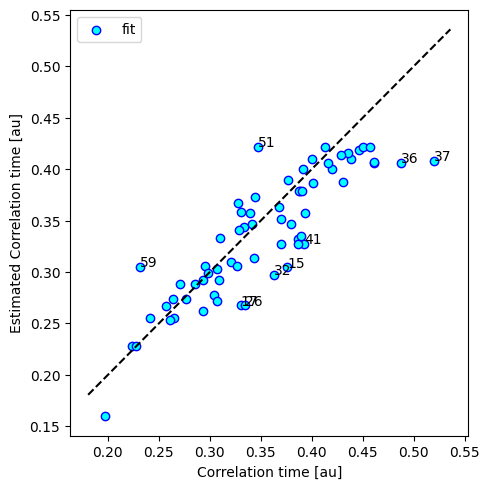

In [9]:
yhat = func(X, *popt)
yhat

df['fit'] = yhat

residual = (y-yhat)
SSR = residual.transpose().dot(residual)
print('SSR =',SSR)


# Plot 
fig, ax = plt.subplots( figsize=(5,5) )
ax.scatter(y,yhat,marker='o',c='cyan',edgecolors='blue',label='fit')
ax.set_xlabel('Correlation time [au]')
ax.set_ylabel('Estimated Correlation time [au]')

xmin, xmax = plt.xlim()
print(xmin,xmax)
xv = np.linspace(xmin,xmax,10)
ax.plot(xv,xv,'--k')

#df = df.sort_values('corr-time[au]')
n = list( df.index )
xn = list( df['corr-time[au]'] )
yn = list( df.fit )
for i in range(len(xn)):
    if ( (xn[i]-yn[i])**2>0.06**2 ):
        ax.annotate(n[i],(xn[i],yn[i]),
                    xytext=(xn[i],yn[i]),
                    #arrowprops=dict(facecolor='black', arrowstyle="->")
                   )
ax.legend()
fig.tight_layout()
fig.savefig(f'FIG02d/Evaluation_Corr_fit_dimers.png',format='png',dpi=300)

df